<a href="https://colab.research.google.com/github/jdasam/mas1004-2023/blob/main/live_coding/5_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import Library and Download data

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2023-11-16 06:07:39--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.07MB/s    in 0.3s    

2023-11-16 06:07:40 (3.07 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


### Import libraries and functions

In [2]:
from tqdm.auto import tqdm
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class RatingSet:
  def __init__(self, csv_path='ml-latest-small/ratings.csv'):
    self.ratings = pd.read_csv(csv_path)

    # how many unique users exist in this dataset
    self.n_users = len(set(self.ratings['userId']))
    self.n_movies = len(set(self.ratings['movieId']))

    # list the every ids of included users
    self.user_ids = list(set(self.ratings['userId']))
    self.movie_ids = sorted(list(set(self.ratings['movieId'])))

    # we have to find in which idx the given movieId exists in this dataset's movie ID
    self.movie2idx = {id: idx for idx, id in enumerate(self.movie_ids)}
    self.user2idx = {id: idx for idx, id in enumerate(self.user_ids)}

  def __len__(self): # how many data sample exists in the dataset
    return len(self.ratings) # number of ratings in the dataset

  def __getitem__(self, idx): # get the idx-th sample from the dataset
    idx_row = self.ratings.iloc[idx]

    user_id = self.user2idx[idx_row.userId]
    movie_id = self.movie2idx[idx_row.movieId]
    rating = idx_row.rating

    return user_id, movie_id, torch.tensor(rating, dtype=torch.float32)

class MatrixFactorizer(nn.Module):
  def __init__(self, n_user, n_movie, n_factor):
    super().__init__()

    self.user_embedding = nn.Embedding(n_user, n_factor)
    self.movie_embedding = nn.Embedding(n_movie, n_factor)

    self.user_embedding.weight.data /= n_factor
    self.movie_embedding.weight.data /= n_factor

    self.scale = 5.5

  def scaled_sigmoid(self, x):
    return 1/(1+torch.exp(-x/self.scale)) * self.scale

  def forward(self, user_id, movie_id):
    user_emb_vec = self.user_embedding(user_id)
    movie_emb_vec = self.movie_embedding(movie_id)

    elem_wise_multiplication_result = user_emb_vec * movie_emb_vec
    dot_prod_result = elem_wise_multiplication_result.sum(dim=1)

    return self.scaled_sigmoid(dot_prod_result)



class MatrixFactorizerWithBias(MatrixFactorizer):
  def __init__(self, n_user, n_movie, n_factor):
    super().__init__(n_user, n_movie, n_factor)
    self.user_bias = nn.Embedding(n_user, 1)
    self.movie_bias = nn.Embedding(n_movie, 1)
    self.user_bias.weight.data = torch.zeros(n_user, 1)
    self.movie_bias.weight.data = torch.zeros(n_movie, 1)


  def forward(self, user_id, movie_id):
    user_emb_vec = self.user_embedding(user_id)
    movie_emb_vec = self.movie_embedding(movie_id)

    elem_wise_multiplication_result = user_emb_vec * movie_emb_vec
    dot_prod_result = elem_wise_multiplication_result.sum(dim=1)
    dot_prod_result += self.user_bias(user_id)[:, 0] + self.movie_bias(movie_id)[:, 0]

    return self.scaled_sigmoid(dot_prod_result)

class Trainer:
  def __init__(self, model, train_loader, valid_loader, model_name='movielens', device='cpu'):
    self.model = model
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.device = device
    self.model.to(self.device)
    self.criterion = nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
    self.acc_threshold = 0.5
    self.best_loss = torch.inf
    self.best_acc = 0.0
    self.train_losses = []
    self.valid_losses = []
    self.train_accs = []
    self.valid_accs = []
    self.model_name = model_name

  def validation(self):
    self.model.eval() # change the model from train mode to evaluation mode
    # Some models work in different ways based on whtehter it is on training step
    # or on inference step

    # In validation step, you don't have to calculate the gradient
    # with torch.no_grad():

    current_loss = 0
    num_total_correct_pred = 0
    with torch.inference_mode(): # every torch computation under this indent
    # will be run without calculating the gradient or computation history
      for batch in self.valid_loader:
        user_ids, movie_ids, ratings = batch
        user_ids, movie_ids, ratings = user_ids.to(self.device), movie_ids.to(self.device), ratings.to(self.device)

        self.optimizer.zero_grad()
        outputs = self.model(user_ids, movie_ids)

        loss = self.criterion(outputs, ratings) # you have to feed log_probs

        num_acc_pred = (torch.abs(outputs - ratings) < self.acc_threshold).sum()

        num_total_correct_pred += num_acc_pred.item()
        # in validation stage, we don't care about single batch's loss
        # we want to see the result for total images of validation set

        current_loss += loss.item() * len(ratings)
        # instead of adding the mean loss, we add sum of loss
        # because the batch size can be different
    mean_loss = current_loss / len(self.valid_loader.dataset)
    mean_acc = num_total_correct_pred / len(self.valid_loader.dataset) # number of total datasample in the validation loader
    return mean_loss, mean_acc
    # return {'loss': mean_loss, 'acc': mean_acc}


  def train_by_number_of_epochs(self, num_epochs):
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
      for batch in tqdm(self.train_loader, leave=False):
        user_ids, movie_ids, ratings = batch
        user_ids, movie_ids, ratings = user_ids.to(self.device), movie_ids.to(self.device), ratings.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(user_ids, movie_ids)

        loss = self.criterion(outputs, ratings) # you have to feed log_probs

        acc = (torch.abs(outputs - ratings) < self.acc_threshold).sum() / len(ratings)
        # for torch.nn.NLLLoss
        loss.backward()
        self.optimizer.step()

        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        # don't try self.train_losses.append(loss)
      # training step has ended
      # we want to test our model on the validation set
      valid_loss, valid_acc = self.validation()

      # is this model the best?
      # let's decide it based on valid_acc
      if valid_acc > self.best_acc:
        self.best_acc = valid_acc

        # If it is the best model, save the model's weight'
        models_parameters = self.model.state_dict()
        print(f"Saving best model at epoch {len(self.valid_accs)}, acc: {valid_acc}")
        torch.save(models_parameters, f'{self.model_name}_best.pt')

      self.valid_losses.append(valid_loss)
      self.valid_accs.append(valid_acc)

    # Plot Accuracy curve
    plt.plot(self.train_accs)
    plt.plot(range(len(self.train_loader)-1, len(self.train_accs), len(self.train_loader)) ,self.valid_accs)
    plt.title("Accuracy")

## Prepare Data Split and DataLoader

In [3]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

movies = movies[movies['movieId'].isin(ratings['movieId'])]
movies.reset_index(drop=True, inplace=True)
movies['title'].to_csv("list_of_movie_titles.csv")

dataset = RatingSet()
num_train = int(len(dataset)*0.9) # 90% is used for the training
num_valid = int(len(dataset)*0.05) # 5% is used for the validation
num_test = len(dataset) - num_train - num_valid # the remaining is used for the test
# num_test = int(len(dataset)*0.05)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset,
                                              [num_train, num_valid, num_test],
                                               generator=torch.Generator().manual_seed(0))
# randomly split the dataset into train/valid/test


train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=512, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False)

In [4]:
# ratings['userId'] # ratings has 100836 ratings
len(set(ratings['userId'].values)) # How many unique users exists?: 610 unique users
# How many unique movies exists?
len(set(ratings['movieId'].values))  # How many unique movie exists?: 9724 unique movies
# Are the movies rated in equal numbers?

from collections import Counter
movie_counter = Counter(ratings['movieId'].values)
movie_counter.most_common(10)

[(356, 329),
 (318, 317),
 (296, 307),
 (593, 279),
 (2571, 278),
 (260, 251),
 (480, 238),
 (110, 237),
 (589, 224),
 (527, 220)]

In [5]:
dataset.movie2idx[362] #movieId to uniqueId
# movieId 362 is 320th movie in our dataset


320

In [6]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [7]:
dataset[1000]

(6, 5791, tensor(3.5000))

In [8]:
train_batch = next(iter(train_loader))
# train_batch
user, item, rating = train_batch

In [12]:
print(user, user.shape)  # 64 integers, representing ID of user for each rating
print(item, item.shape)  # 64 integers representing ID of movie for each rating
print(rating, rating.shape) # 64 float values (0.5 - 5.0) representing the score of each rating

tensor([201, 306, 468, 143, 521, 447, 427, 379, 325, 605, 173, 173,  20, 489,
        599, 287, 598, 178, 404, 602,  78, 104, 513, 473, 136, 595,  16,  84,
        164, 341, 526,  67,  88, 416, 447, 293,  22,  58, 245, 397, 479, 104,
        181, 306,  90, 524,  67,  73, 598, 120, 296, 379, 355, 447, 265, 338,
        233,  41, 516,  20, 176, 110, 124, 352]) torch.Size([64])
tensor([1043, 6511,  967, 2979, 7307, 8572, 1008, 4786, 7537, 4796,  166,  202,
        7285, 6501, 6471,  812, 2522,  302, 1257, 1753, 2019,  697,  412, 1160,
        1290,  507,  928, 1070, 3953, 2391, 1575, 2171, 9514,  827, 3002, 1605,
        4963, 1098, 3633,  899,  302, 5780, 1291, 6236, 1056, 6203, 5682, 5113,
        2742,    5,  645, 8632, 2035, 3094,  483, 6912,  899, 1070, 5324, 6630,
        6612, 8218,  983,  508]) torch.Size([64])
tensor([3.0000, 4.5000, 4.0000, 4.5000, 4.0000, 2.5000, 2.5000, 4.0000, 4.5000,
        4.0000, 2.0000, 5.0000, 3.5000, 3.0000, 4.0000, 2.0000, 1.5000, 3.0000,
        4.00

In [59]:
class MatrixFactorizer(nn.Module):
  def __init__(self, n_users, n_items, emb_size=32):
    super().__init__()
    self.user_embedding = nn.Embedding(n_users, emb_size)
    self.movie_embedding = nn.Embedding(n_items, emb_size)

    self.user_embedding.weight.data /= 5
    self.movie_embedding.weight.data /= 5

    # We can add bias term
    # Some users always give higher score or lower score compare to the others
    # Some movies always gets higher score regardless of users' tastes

    self.user_bias = nn.Embedding(n_users, 1)
    self.movie_bias = nn.Embedding(n_items, 1)
    # Bias are usually initialized to 0
    self.user_bias.weight.data = torch.zeros_like(self.user_bias.weight.data)
    self.movie_bias.weight.data = torch.zeros_like(self.movie_bias.weight.data)

  def forward(self, user, item):
    # user: torch.LongTensor of shape [BatchSize]
    # item: torch.LongTensor of shape [BatchSize]
    user_embs = self.user_embedding(user)
    item_embs = self.movie_embedding(item)
    # ratings = (user_embs * item_embs).sum(dim=1)
    ratings = torch.stack([torch.dot(u,i) for u, i in zip(user_embs, item_embs)], dim=0) # shape: [BatchSize]

    user_bias = self.user_bias(user) # shape: [BatchSize, 1]
    item_bias = self.movie_bias(item) # shape: [BatchSize, 1]
    ratings += user_bias[:,0] + item_bias[:,0]

    return scale_func(ratings)

model = MatrixFactorizer(dataset.n_users, dataset.n_movies)
estimated_ratings = model(user, item)

loss = ((estimated_ratings - rating) ** 2).mean()
loss

tensor(1.7670, grad_fn=<MeanBackward0>)

In [42]:
# our desired output range is 0.5 - 5.0
estimated_ratings

tensor([2.5072, 2.2614, 2.7689, 2.9535, 3.1927, 2.9213, 3.3011, 2.8932, 2.7468,
        2.6127, 2.8330, 3.0359, 2.4825, 3.0852, 2.5510, 2.7960, 3.0955, 2.5766,
        2.7227, 2.4331, 2.8388, 2.9011, 2.6245, 3.4899, 2.8220, 2.9985, 2.7690,
        3.4263, 2.9977, 1.9095, 2.6950, 2.5838, 1.9851, 3.2545, 2.8340, 3.1855,
        2.7124, 2.9349, 3.1474, 2.9529, 3.0317, 2.2917, 2.5333, 2.6513, 2.9128,
        3.3158, 2.6237, 2.4694, 2.4773, 2.1140, 3.0890, 2.2730, 2.9035, 2.6146,
        2.7140, 2.5695, 2.9129, 3.2779, 3.1201, 2.6734, 3.2098, 3.1485, 2.6493,
        2.7708], grad_fn=<MulBackward0>)

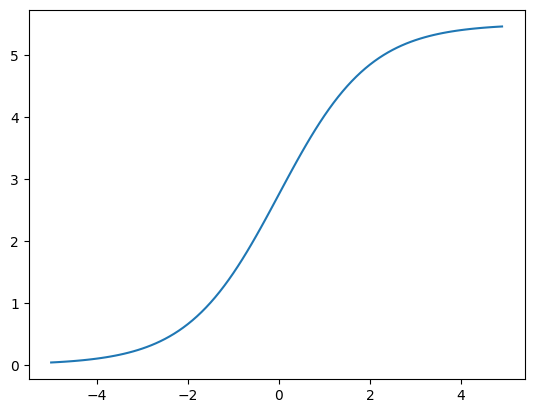

In [40]:
# Let's make a scale function using sigmoid
# Our scale function takes any range of real number and output the value between 0 - 5.5
def scale_func(x):
  return 5.5 / (1 + torch.exp(-x))

input_x =( torch.arange(100) - 50) / 10
output_y = scale_func(input_x)

import matplotlib.pyplot as plt
plt.plot(input_x, output_y)

In [35]:
model.user_embedding.weight

Parameter containing:
tensor([[-0.4332,  0.8321, -0.2507,  ..., -1.6110, -0.5892, -0.4966],
        [-0.9514, -0.4461,  0.7440,  ...,  0.1693,  1.3386,  0.6830],
        [-1.3046,  0.0785,  1.5610,  ...,  1.6140, -0.7015, -0.5609],
        ...,
        [ 0.5926, -1.6051,  0.5481,  ...,  0.2476,  0.2591, -0.0480],
        [-0.3809, -0.5333,  1.0066,  ...,  0.9466,  0.7886, -0.7374],
        [ 0.3037, -0.0956,  0.6444,  ...,  0.0796,  0.5563, -1.1835]],
       requires_grad=True)

In [20]:
torch.set_printoptions(sci_mode=False)

In [28]:
# Model takes (user ID and movie ID), and estimates the rating score of the movie by the given user

# The model converts user ID into a user embedding
user_id = user[0:3]
print(user_id, user_id.shape)
item_id = item[0:3]
print(item_id, item_id.shape)
user_emb = model.user_embedding(user_id)
print(user_emb, user_emb.shape)
# The model can convert movie ID into a movie embedding
item_emb = model.movie_embedding(item_id)
print(item_emb, item_emb.shape)

out = user_emb * item_emb
out_sum = out.sum(dim=1)
print(out, out.shape)
print(out_sum, out_sum.shape)

tensor([201, 306, 468]) torch.Size([3])
tensor([1043, 6511,  967]) torch.Size([3])
tensor([[    -1.7346,      0.3231,      2.0028,     -0.4986,      0.8656,
              2.4215,     -0.0694,      1.5671,     -1.1851,     -2.4179,
              0.8504,     -1.0280,      0.1178,     -0.2578,     -0.3241,
              0.1395,      1.5041,      0.4540,      0.8833,     -0.0183,
             -1.4805,      0.4346,     -0.1449,     -1.2439,     -0.0889,
             -0.0290,      0.3837,     -0.7831,     -1.8396,     -0.9640,
              1.1122,      0.0022],
        [     0.9389,      0.1433,     -1.2471,      1.2819,      1.1305,
             -0.0746,     -0.2843,      0.2654,     -0.3773,     -1.8451,
              0.5940,     -0.3061,      0.2237,     -0.6967,      1.1979,
             -0.7906,     -0.4566,     -0.3806,     -1.6096,     -0.9699,
             -0.5248,      0.4230,     -2.3089,      0.6864,     -2.7536,
              0.0657,      0.5473,      0.4263,      0.6744,      0

In [31]:
for u, i in zip(user_emb, item_emb):
  print(torch.dot(u,i))

torch.stack([torch.dot(u,i) for u, i in zip(user_emb, item_emb)], dim=0)


tensor(1.4718, grad_fn=<DotBackward0>)
tensor(-0.4600, grad_fn=<DotBackward0>)
tensor(-2.1203, grad_fn=<DotBackward0>)


tensor([ 1.4718, -0.4600, -2.1203], grad_fn=<StackBackward0>)

In [60]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
DEV = 'cuda'
model = MatrixFactorizer(dataset.n_users, dataset.n_movies)
model.to(DEV)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

num_epochs = 3

loss_record = []

for epoch in tqdm(range(num_epochs)):
  for batch in tqdm(train_loader, leave=False):
    user, item, rating = batch
    estimated_ratings = model(user.to(DEV), item.to(DEV))
    loss = ((estimated_ratings - rating.to(DEV)) ** 2).mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

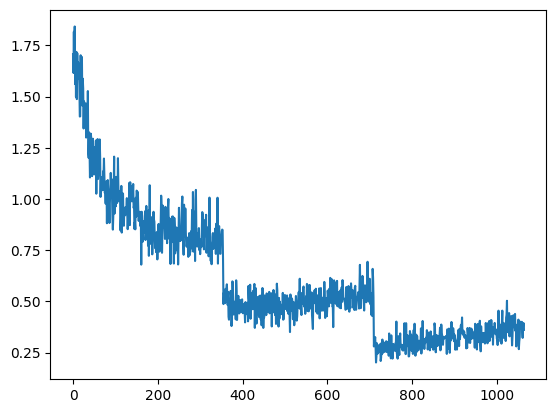

In [61]:
plt.plot(loss_record)

In [62]:
model.to('cpu')
estimated_ratings = model(user, item)

loss = ((estimated_ratings - rating) ** 2).mean()
loss

tensor(0.2649, grad_fn=<MeanBackward0>)

In [63]:
estimated_ratings

tensor([3.8922, 2.3191, 4.3560, 4.4157, 4.6399, 4.4044, 3.7939, 4.1541, 4.1518,
        3.9520, 1.1103, 4.2031, 2.9370, 3.8968, 4.1461, 4.0448, 2.9991, 3.2684,
        2.8123, 3.9875, 3.6631, 4.4365, 4.6928, 4.4015, 4.5942, 1.9468, 3.6178,
        3.4978, 2.9288, 4.1832, 3.8399, 3.2272, 3.7554, 3.5469, 4.2424, 4.4259,
        3.0834, 3.7923, 2.8381, 3.4588, 3.7166, 3.1507, 4.0612, 4.2482, 4.2173,
        5.0174, 4.0214, 1.7065, 3.1276, 3.0949, 1.5662, 2.1189, 4.1353, 3.3403,
        3.3199, 1.8417, 2.9613, 1.4612, 3.7942, 3.1998, 4.2812, 3.3937, 3.1759,
        2.6935, 3.1747, 3.7742, 4.2204, 4.1819, 4.1472, 4.3716, 3.8014, 3.4917,
        4.2966, 4.6196, 3.7455, 3.7257, 3.1975, 4.1001, 4.8654, 4.2206, 3.3228,
        4.0844, 1.6040, 4.3118, 4.5362, 2.4574, 4.0671, 4.3914, 3.4076, 5.0816,
        2.5303, 3.5234, 4.4316, 4.5935, 4.5647, 3.4053, 3.4164, 2.5276, 3.6143,
        3.3711, 3.5364, 4.3747, 4.5758, 3.6912, 4.2246, 3.6863, 3.5434, 3.8257,
        1.5974, 3.4423, 4.5351, 3.0414, 

In [66]:
torch.argmax(model.movie_bias.weight)

tensor(277)

In [67]:
model.movie_bias.weight[277]

tensor([1.0309], grad_fn=<SelectBackward0>)

In [70]:
dataset.movie_ids[277]

318

In [71]:
dataset.movie2idx[314]

273

In [72]:
model.movie_bias.weight[273]

tensor([0.2566], grad_fn=<SelectBackward0>)